<span style="font-size: x-large;">**IMPOSTAZIONE AMBIENTE DI LAVORO**<span style="font-size: x-large;">  
 
<span style="font-size: large;">**1. Creazione cartelle**  
 
Come primo passo, organizziamo lo spazio di lavoro dove salvare dati, risultati e figure dell'esperienza di laboratorio. Creiamo quindi le seguenti cartelle di lavoro sul computer:  
- *DATI_ORIGINALI*  
    cartella dove salvare i dati delle stazioni Davis originali. I dati possono essere scaricati dal virtuale del corso di "Laboratorio di Fisica dell'Atmosfera" al seguente link:
https://virtuale.unibo.it/course/view.php?id=51454#section-3 
- *DATI_PROCESSATI*  
    cartella dove salvare i dati processati delle stazioni Davis e i risultati delle analisi che verranno effettute durante le esperienze di laboratorio.  
- *FIGURE*  
    cartella dove salvare le figure da inserire successivamente nell'elaborato finale descrivente le esperienze di laboratorio.  
  
I nomi delle cartelle possono ovviamente essere scelti a piacimento.
Si consiglia però di organizzare in cartelle separate i dati originali e i dati processati, al fine di evitare di confodere gli uni con gli altri al momento delle analisi.


<span style="font-size: large;">**2. Inizializzazione ambiente di calcolo**  

Una volta creato lo spazio di lavoro sul proprio computer, inizializziamo l’ambiente di calcolo di Python caricando i pacchetti necessari alla gestione dei dati, alla loro analisi e alla rappresentazione grafica dei risultati ottenuti.  

In [80]:
# Pacchetto per apertura dati salvati in cartelle zippate
import zipfile

# Pacchetti per analisi dati
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import warnings; warnings.simplefilter("ignore")
from functools import reduce
from sklearn.linear_model import LinearRegression
import math
import pytz

# Pacchetti per visualizzazioni grafiche
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import calendar
from collections import Counter

<span style="font-size: x-large;">**GESTIONE DATI**</span>  
  
  **<span style="font-size: large;">1. Estrazione dati da cartella ZIP**

I dati delle 3 stazioni Davis sono salvati all'interno di un file ZIP. Attraverso il pacchetto Python *"zipfile"* è possibile estrarre i file della cartella compressa direttamente da Python e salvarli nel percorso scelto.

In [81]:
percorso = "./DATI_ORIGINALI/"

# Il percorso va cambiato in funzione di dove sono i vostri dati
nome_file = "Dati_Stazione.zip"
file= str(percorso)+str(nome_file)

with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall(percorso)

  **<span style="font-size: large;">2. Lettura dati**  
    
I modi per aprire e leggere file in Python sono molteplici e la scelta migliore dipende dal formato dei dati e dalla loro struttura. Pacchetti particolarmente usati a questo scopo sono *"xarray"* (specialmente per dati climatici in formato netcdf ".nc"), *"numpy"* e *"pandas"*.  

I dati delle stazioni Davis sono salvati in tre differenti file ".txt", ciascuno associato ad una singola stazione Davis. Questi file sono costruiti in formato tabellare, in modo da avere nelle prime tre colonne la data, l'orario e l'intervallo temporale, mentre nelle successive colonne vengono riportate le misurazioni di diverse variabili fisiche. 
    
Per capire meglio come sono fatti, apriamo uno dei file ".txt".

Una scelta idonea, ma non unica, per aprire file in formato tabellare è adoperare il pacchetto *"pandas"*.  

Al fine di evitare di ripetere l'operazione di apertura dei file per ciascuna singola stazione, si è impostato un ciclo *"for"* reiterando l'operazione di lettura dei dati un numero di volte pari al numero delle stazioni stesse. Seppur questo non sia necessario ai fini della funzionalità dello script, ne aiuta molto la leggibilità.
    
Onde evitare problemi con la successiva gestione dei dataframes, si procede con l'aprire i dati delle stazioni con un approccio quanto più generale possibile, vale a dire:

- leggere i dati riga per riga (eliminando tutti gli spazi bianchi tra le colonne),
- salvare le righe in un oggetto "lista" e poi trasformarlo in un dataframe
- tenere solo le righe del dataframe della stazione C dove tutte le colonne contengono solo caratteri alfabetici (a-zA-Z), caratteri numerici (0-9) o il segno meno (-).    

In [82]:
stazioni = ["A","B","C"]

for stazione in stazioni:
    
    print("Stazione "+stazione)

    file = percorso+"Dati Meteo - Stazione "+stazione+".txt"
    
    # Di seguito si inizializza una lista vuota, all'interno della quale si va a caricare ogni linea della tabella ".txt".
    # In questo contesto, è importante notare che ogni colonna dei file è separata da spazi bianchi, che devono essere tenuti 
    # in considerazione al momento del caricamento dei dati.
    # Per farlo, si adopera "line.split()", che legge riga per riga la tabella ".txt" (compreso il nome delle colonne) ed 
    # elimina tutti gli spazi tra una colonna e l'altra.

    lista = []
    with open(file, encoding='ISO-8859-1') as f:
        for line in f:
            l = line.split()
            lista.append(l)
    
    # A questo punto, trasformiamo la lista in un DataFrame di pandas, con le colonne nominate come nel file originale.
    df = pd.DataFrame(lista[1:],columns=lista[0])
    
    # Seppur non necessario ai fini delle analisi, con i prossimi due comandi si sistemano le intestazioni delle colonne:
    # 1. Eliminiamo la virgola alla fine dei nomi delle diverse colonne nel file originale (es. "wndSpeed,")
    df.columns = df.columns.str.rstrip(',')    
    # 2. Eliminiamo il carattere "#" di fronte alla parola "Date" della prima colonna ("#Date")
    nome_prima_colonna = df.columns[0][1:]
    df.rename(columns={df.columns[0]: nome_prima_colonna}, inplace=True)
    
    # I dati della stazione C presentano dei caratteri verso la fine dell'intervallo temporale che non sono facilmente decifrati/interpretati da python.
    # Si procede quindi a selezionare solo quelle righe del dataframe della stazione C dove tutte le colonne contengono solo 
    # caratteri alfabetici (a-zA-Z), caratteri numerici (0-9) e il segno meno (-).
    
    if stazione == "C":
        for col in range(df.shape[1]):
            column = df.columns[col]
            mask = df[str(column)].str.contains(r'^[a-zA-Z0-9.-]+$', na=False)
            df = df[mask]
    else:
        pass
        
    globals()['df_'+stazione] = df

Stazione A
Stazione B
Stazione C


In [83]:
df_A;

<span style="font-size: large;">**3. La variabile *Tempo***  
  
Le prime tre colonne dei file rappresentano la data, l'orario e l'intervallo temporale delle misurazioni.

Quando si lavora con dati meteo-climatici, la dimensione "tempo" è fondamentale in quanto la maggior parte delle operazioni di gestione dei dati viene spesso svolta proprio lungo questa dimensione. Per questo motivo, molti pacchetti (non solo in Python) sono costruiti proprio per agevolare specifiche operazioni lungo la dimensione temporale, quali ad esempio medie mensili, calcolo della climatologia, selezione dei dati di una sola stagione, etc.

Dato che anche durante questa esperienza di laboratorio dovremo effettuare diverse operazioni lungo la dimensione temporale, conviene creare una nuova variabile di supporto (*"Datetime"*) contente le date in formato Anno-mese-giorno ora:minuto.

Nello script di seguito, le colonne originali *"Date"* e *"Time"* vengono eliminate a seguito della creazione della colonna *"Datetime"* con il fine ultimo di avere dataframes non ridondanti e più facili da intepretare e leggere. Queste colonne possono però essere mantenute all'interno dei dataframes senza alcun problema.

In [84]:
stazioni = ["A","B","C"]

for stazione in stazioni:
    
    print("Stazione "+stazione)
    
    df = globals()["df_"+stazione]
        
    day = df['Date'].values; hour = df['Time'].values
    date_final = np.array([datetime.strptime(data + ' ' + ora, "%Y%m%d %H.%M") for data, ora in zip(day, hour)])
    df.insert(2,'Datetime',date_final)
    df.drop(df.columns[:2],axis=1, inplace=True)
            
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
                    
    globals()["df_"+stazione] = df #non serve se non uso copy in df = 

Stazione A
Stazione B
Stazione C


Dando una occhiata più attenta ai dati della stazione A, ci si rende conto che la variabile *"Datetime"* non è ordinata. Difatti le ore non sono disposte in modo regolare. Si procede quindi a riordinare tutti i dataframes lungo la dimensione temporale con *"sort_values(by='Datetime')"*.  

Inoltre, guardando la dimensione *"Interval"* si vede che le misure sono state prese a diversi intervalli temporali, cosa di cui si dovrà tener conto al momento dell'analisi dei dati.

In [85]:
stazioni = ["A","B","C"]

for stazione in stazioni:
    
    globals()["df_"+stazione] = globals()["df_"+stazione].sort_values(by='Datetime', ignore_index=True) #riordina indici di riga

<span style="font-size: large;">**4. Qualche operazione di base**
    
Ora che abbiamo aperto i dati e abbiamo sistemato la dimensione tempo, cominciamo ad imparare a manipolare i dati delle stazioni meteo con qualche operazione di base.

<span style="font-size: x-large;">**GRAFICI**</span>  

In questa sezione, si forniscono alcuni esempi di grafici che potrebbero risultare utili ai fini dell'analisi dei dati delle stazioni Davis.  

<u>NOTA IMPORTANTE</u>: I grafici devono SEMPRE essere corredati di tutte le informazioni necessarie a comprenderli, anche quando possono sembrare banali e ridondanti: titolo degli assi, unità di misura di tutte le variabili richiamate, legenda, barra dei colori, limite degli assi ben definiti, etc. 
  
  <span style="font-size: large;">**1. Istogrammi**  
  
  Gli istogrammi sono una rappresentazione grafica della distribuzione di un insieme di dati, che mostra la frequenza con cui ciascun valore o intervallo di valori si verifica in un insieme di dati. Gli istogrammi sono comunemente utilizzati per esaminare la forma della distribuzione di dati numerici e per identificare tendenze, modi, e altre caratteristiche.

Ai fini di una rappresentazione grafica intuitiva, solitamente l'asse x degli istrogrammi rappresenta il range dei dati diviso in intervalli o "bin". L'asse y invece rappresenta la frequenza con cui i dati ricadono in ciascun bin. Quindi, l'altezza di ciascun bin rappresenta il numero di osservazioni che rientrano in uno specifico intervallo.  

I metodi per produrre istogrammi su python sono diversi. Un approccio molto usato è adoperare la libreria *"seaborn"*, vale a dire una libreria di visualizzazione dati per analisi statistiche. Un altro approccio, consigliabile in casi semplici, è disegnare direttamente delle barre rettangolari in un piano cartesiano, con specifiche posizioni lungo l'asse x e dimensioni lungo l'asse y.  

Di seguito si riportano due esempi, cogliendo l'occasione per analizzare i dati delle stazioni Davis.

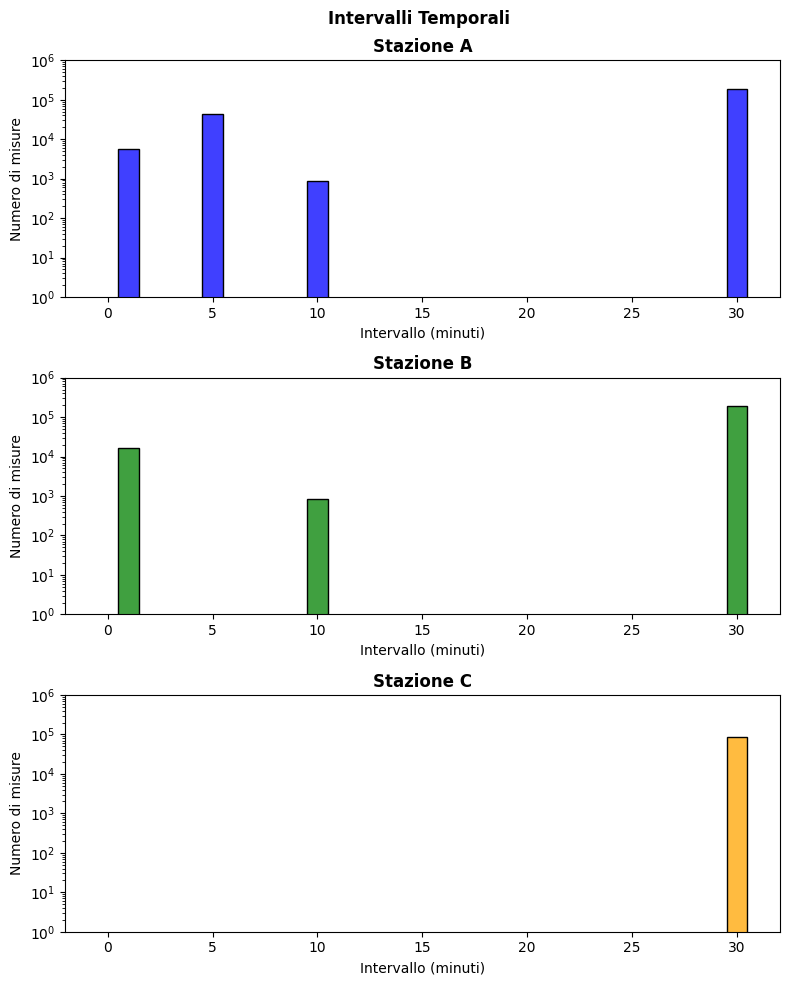

In [86]:
# ESEMPIO 1. Come si distribuiscono le diverse risoluzioni temporali?

plt.figure(figsize=(8, 10))

plt.subplot(3, 1, 1)
bins = np.arange(-0.5,int(df_A['Interval'].max())+1)
hist = sns.histplot(df_A['Interval'], bins=bins,kde=False, color='blue')
plt.yscale('log')
plt.title('Stazione A',fontweight='bold')
plt.ylabel("Numero di misure"); plt.xlabel("Intervallo (minuti)")
plt.ylim(10**(0),10**(6))

plt.subplot(3, 1, 2)
bins = np.arange(-0.5,int(df_B['Interval'].max())+1)
hist = sns.histplot(df_B['Interval'], bins=bins,kde=False, color='green')
plt.yscale('log')
plt.title('Stazione B',fontweight='bold')
plt.ylabel("Numero di misure"); plt.xlabel("Intervallo (minuti)")
plt.ylim(10**(0),10**(6))

plt.subplot(3, 1, 3)
bins = np.arange(-0.5,int(df_C['Interval'].max())+1)
hist = sns.histplot(df_C['Interval'], bins=bins,kde=False, color='orange')
plt.yscale('log')
plt.title('Stazione C',fontweight='bold')
plt.ylabel("Numero di misure"); plt.xlabel("Intervallo (minuti)")
plt.ylim(10**(0),10**(6))

plt.suptitle('Intervalli Temporali',fontweight='bold',x=0.53)

plt.tight_layout()
plt.show()


Come si può vedere, la stazione A presenta dei dati presi a intervalli temporali pari a [1, 5, 10] minuti, mentre la stazione B a [1, 10] minuti.  
Se vogliamo solo misure provenienti da letture ogni 30 minuti e allo scoccare dell'ora e della mezz'ora (come per la stazione C), basta applicare dei filtri imponendo delle condizioni lungo le colonne *"Datetime*" e *"Interval"*.

In [87]:
stazioni = ["A","B","C"]

for stazione in stazioni:
    
    print(f"Stazione {stazione}")
    
    df = globals()["df_"+stazione].copy() #sono dati raw con colonna datetime unica e ordinata per datetime con nuovi indici
    
    # Il simbolo "|" sta ad indicare la funzione logica "or", mentre il simbolo "&" sta a indicare la funzione logica "and"
    globals()["df_"+stazione+"_interval30"] = df[((df.Datetime.dt.minute == 0)|(df.Datetime.dt.minute == 30))&(df.Interval == 30)]
    print(globals()["df_"+stazione+"_interval30"].Interval.min()) #verify


Stazione A
30.0
Stazione B
30.0
Stazione C
30.0


In [88]:
# ESEMPIO 2. Come sono distribuiti i dati rispetto gli anni e le stagioni?

# Dividiamo i dati in stagioni
stazioni = ["A","B","C"]

for stazione in stazioni:
    
    print(f"Stazione {stazione}")
    
    df = globals()["df_"+stazione+"_interval30"].copy()
    
    # Procediamo in questo modo:
    
    # 1. Applichiamo dei filtri per selezionare solo i mesi di interesse per le stagioni "DJF", "MAM", "JJA" e "SON"
    
    df_DJF = df[(df["Datetime"].dt.month == 12)|(df["Datetime"].dt.month == 1)|(df["Datetime"].dt.month == 2)]
    df_MAM = df[(df["Datetime"].dt.month == 4)|(df["Datetime"].dt.month == 4)|(df["Datetime"].dt.month == 5)]
    df_JJA = df[(df["Datetime"].dt.month == 6)|(df["Datetime"].dt.month == 7)|(df["Datetime"].dt.month == 8)]
    df_SON = df[(df["Datetime"].dt.month == 9)|(df["Datetime"].dt.month == 10)|(df["Datetime"].dt.month == 11)]
    
    # 2. Raggruppiamo i dati in base agli anni del dataframe (con la funzione "groupby()")
    # 4. Contiamo il numero di righe di ciascun anno (con la funzione aggregazione "agg()"), denominando la nuova colonna 
    # "count_DJF", etc.
    # 4. Ripristiniamo l'indice degli anni come prima colonna del dataframe (con la funzione "reset_index()")
    
    count_DJF = df_DJF.groupby(df_DJF.Datetime.dt.year).agg(count_DJF=('Interval', 'size')).reset_index()
    count_MAM = df_MAM.groupby(df_MAM.Datetime.dt.year).agg(count_MAM=('Interval', 'size')).reset_index()
    count_JJA = df_JJA.groupby(df_JJA.Datetime.dt.year).agg(count_JJA=('Interval', 'size')).reset_index()
    count_SON = df_SON.groupby(df_SON.Datetime.dt.year).agg(count_SON=('Interval', 'size')).reset_index()
    
    # 5. Concateniamo i 4 dataframes relativi alle stagioni in una lista
    
    dfs = [count_DJF, count_MAM, count_JJA, count_SON]
    
    # 6. Uniamo i dataframes (attraverso la funzione "pd.merge()") lungo la dimesione "Datetime" (specificando [on="Datetime"]). 
    # La specifica [how="outer"] serve a creare una prima colonna unendo gli anni di tutti i dataframes.
    
    df_merged = dfs[0].merge(dfs[1], on='Datetime', how='outer')
    for df in dfs[2:]:
        df_merged = df_merged.merge(df, on='Datetime', how='outer')
    
    # 7. Sostituico con zero i valori NaN.
    # Dato che non tutti i dataframes hanno misurazioni in tutti gli anni, le misure mancanti vengono sostituite con "NaN" 
    # dalla funzione "pd.merge()"
    
    df_merged = df_merged.fillna(0).rename(columns={"count_DJF":"DJF","count_MAM":"MAM","count_JJA":"JJA","count_SON":"SON"})
    
    globals()["count_"+stazione] = df_merged
    
count_A


Stazione A
Stazione B
Stazione C


,Datetime,DJF,MAM,JJA,SON
0,2005,0.0,0.0,0.0,3233
1,2007,1488.0,0.0,0.0,3843
2,2008,4368.0,2928.0,4416.0,4081
3,2009,3911.0,2922.0,4416.0,4366
4,2010,3145.0,2928.0,4416.0,4321
5,2011,933.0,2896.0,1708.0,3096
6,2012,3115.0,0.0,2433.0,4265
7,2013,4314.0,2928.0,2280.0,3450
8,2014,4320.0,2928.0,4416.0,4368
9,2015,4319.0,2928.0,4416.0,4367


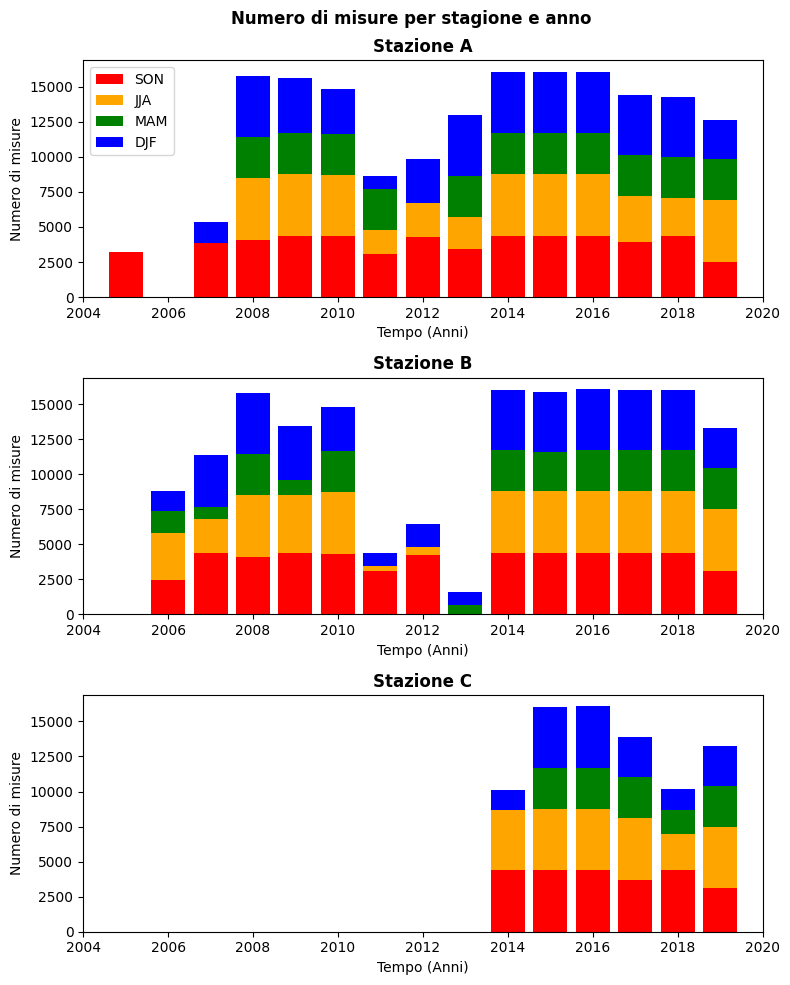

In [89]:
# Plot

plt.figure(figsize=(8, 10))
colors = {'SON': 'red', 'JJA': 'orange', 'MAM': 'green', 'DJF': 'blue'}

plt.subplot(3, 1, 1)
bottom = 0
for stagione, color in colors.items():
    plt.bar(count_A.Datetime, count_A[stagione], color=color, label=stagione,bottom=bottom)
    bottom += count_A[stagione]
plt.xlabel('Tempo (Anni)')
plt.ylabel('Numero di misure')
plt.title('Stazione A',fontweight="bold")
plt.legend()
plt.xlim(2004,2020)

plt.subplot(3, 1, 2)
bottom = 0
for stagione, color in colors.items():
    plt.bar(count_B.Datetime, count_B[stagione], color=color, label=stagione,bottom=bottom)
    bottom += count_B[stagione]
plt.xlabel('Tempo (Anni)')
plt.ylabel('Numero di misure')
plt.title('Stazione B',fontweight="bold")
#plt.legend(reverse=True)
plt.xlim(2004,2020)

plt.subplot(3, 1, 3)
bottom = 0
for stagione, color in colors.items():
    plt.bar(count_C.Datetime, count_C[stagione], color=color, label=stagione,bottom=bottom)
    bottom += count_C[stagione]
plt.xlabel('Tempo (Anni)')
plt.ylabel('Numero di misure')
plt.title('Stazione C',fontweight="bold")
#plt.legend(reverse=True)
plt.xlim(2004,2020)

plt.suptitle('Numero di misure per stagione e anno',fontweight="bold",x=0.52)
plt.tight_layout()
plt.show()

Si noti un funzionamento discontinuo negli anni dal 2011 al 2013, mentre dal 2008 al 2010 e soprattutto dal 2014 al 2016 i dati sono abbastanza uniformemente distribuiti tra le annate e le stagioni, per poi peggiorare leggermente negli anni più recenti.

  <span style="font-size: large;">**2. Diagrammi a dispersione**  
  
  I diagrammi a dispersione, anche detti scatter plots, sono dei grafici costruiti andando a collezionare una serie di punti su uno spazio cartesiano, con ogni asse dello spazio rappresentato da una variabile di interesse. Questo tipo di grafico è particolarmente utile perché permette di evidenziare la relazione tra due o più variabili, individuando eventuali pattern e/o tendenze nei dati.  
  
  Si riporta di seguito, giusto a titolo esemplificativo, il diagramma a dispersione tra la variabile *"Radiazione Totale"* e *"UV"*, mappato in funzione della *"Temperatura"*.

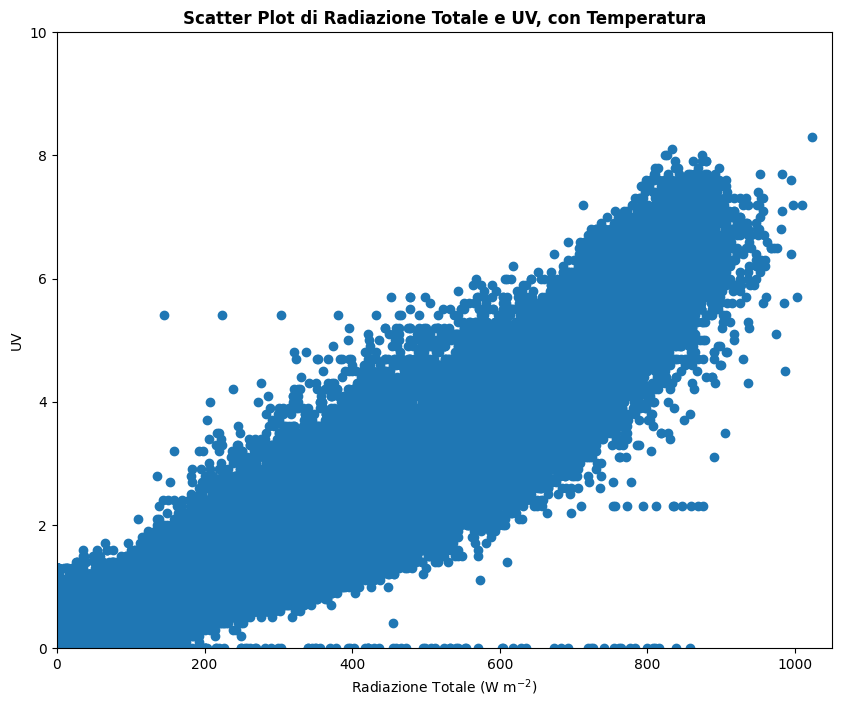

In [90]:
plt.figure(figsize=(10, 8))

scatter_plot = plt.scatter(df_A_interval30['totRad'], df_A_interval30['UV'])

plt.xlabel('Radiazione Totale (W m$^{-2}$)')
plt.xlim(0,1050)

plt.ylabel('UV')
plt.ylim(0,10)

plt.title('Scatter Plot di Radiazione Totale e UV, con Temperatura', fontweight="bold")

plt.show()

I diagrammi a dispersione possono aggiungere più informazioni, andando a mappare la relazione tra le due variabili di interesse in funzione di una terza variabile. Si riporta di seguito, sempre a titolo di esempio, il diagramma a dispersione tra la variabile "Radiazione Totale" e "UV", mappato in funzione della "Temperatura", per la sola Stazione A.

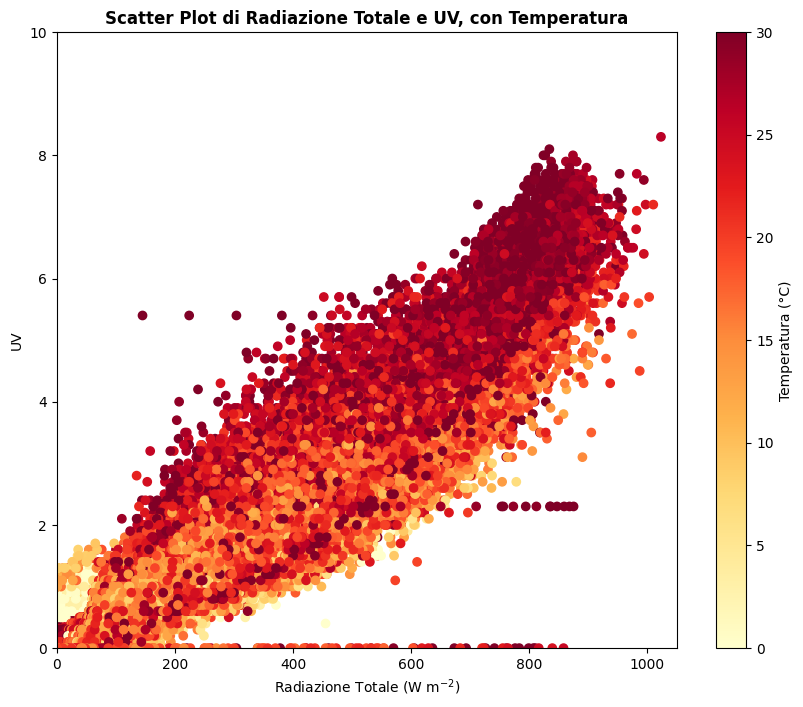

In [91]:
plt.figure(figsize=(10, 8))

scatter_plot = plt.scatter(df_A_interval30['totRad'], df_A_interval30['UV'], 
                           c=df_A_interval30['outTemp'],vmin=0, vmax=30, cmap='YlOrRd')

plt.xlabel('Radiazione Totale (W m$^{-2}$)')
plt.xlim(0,1050)

plt.ylabel('UV')
plt.ylim(0,10)

plt.colorbar(scatter_plot, label='Temperatura (°C)')

plt.title('Scatter Plot di Radiazione Totale e UV, con Temperatura', fontweight="bold")

plt.show()

  <span style="font-size: large;">**4. Timeseries**  
    
Analizzare le evoluzioni temporali delle variabili fisiche su specifiche scale temporali può fornire molte informazioni in merito ai fenomeni analizzati.  

Si plottano di seguito, a titolo di esempio, i cicli diurni medi della velocità del vento e della temperatura della stazione A per le 4 stagioni DJF, MAM, JJA e SON.

<span style="font-size: x-large;">**SALVATAGGIO**<span style="font-size: x-large;">

Una volta sviluppati i grafici di interesse, possiamo salvarli così da poterli adoperare per la redazione dell'elaborato finale.

Si mostra a titolo di esempio come salvare il grafico delle timeseries appena sviluppato.

percorso = "./FIGURE/"
name = 'StazioneA_Vento_vs_Temperatura.png'
fig_timeseries.savefig(percorso+name) # "fig_timeseries" è il nome dato al grafico nella parte di codice della casella sopra. 

<span style="font-size: x-large;">**ANALISI DI DATI DI VENTO**<span style="font-size: x-large;">  
    
Fatta questa piccola introduzione, iniziamo l'esperienza di laboratorio vera e propria, andando ad analizzare i dati di vento delle stazioni Davis.

<span style="font-size: large;">**FILTRI** 
    
<span style="font-size: large;">**1. Filtro temporale**  
    
Dall'istogramma espolaritivo della distribuzione dei dati mostrato in precedenza, si vede che le misure effettuate con le stazioni Davis non sono distribuite uniformemente nel tempo. Per questo motivo bisogna scegliere oculatamente l'intervallo temporale in cui svolgere le analisi, in modo da avere un numero alto di dati e distribuiti nel modo più omogeneo possibile sia tra le stagioni che tra le annate. 
    
A titolo esemplificativo, si procede col filtrare le misure della stazione A. Nello specifico, si selezionano i dati del 2014, 2015 e 2016, che rispettano le condizioni di numerosità e omogeneità richiamate sopra.

In [92]:
def get_season(month):
    if 3 <= month <= 5:
        return 'MAM'
    elif 6 <= month <= 8:
        return 'JJA'
    elif 9 <= month <= 11:
        return 'SON'
    else:
        return 'DJF'

stazioni = ["A","B","C"]

for stazione in stazioni:
    print("STAZIONE_"+stazione)
    df = globals()["df_"+stazione].copy()  #sono dati raw con colonna datetime unica e ordinata per datetime con nuovi indici

    df['Stagione'] = df['Datetime'].dt.month.apply(get_season) #aggiungo indice di stagione
    df_year = df[(df["Datetime"].dt.year >= 2015)&(df["Datetime"].dt.year <= 2016)]
    globals()["df_"+stazione+"_year"] = df_year
    print("raw   " + str(df_year.shape[0]))

    # Qui riapplico la condizione già adoperata in precedenza in merito all'intervallo tra le misure.
    # solo misure a 00 e 30 minuti
    globals()["df_"+stazione+"_year_interval30"] = df_year[((df_year.Datetime.dt.minute == 0)|(df_year.Datetime.dt.minute == 30))&
                                 (df_year.Interval == 30)]
    print("rimaste  " + str(globals()["df_"+stazione+"_year_interval30"].shape[0]))

STAZIONE_A
raw   35083
rimaste  35082
STAZIONE_B
raw   34948
rimaste  34947
STAZIONE_C
raw   35084
rimaste  35083


  <span style="font-size: large;">**2. Filtro di intensità e direzione**  

Come indicato dalle linee guida dell'Environmental Protection Agency (EPA, Agenzia statunitense per la protezione dell'ambiente), le misure di vento possono essere considerate attendibili se vengono rispettate le seguenti condizioni sulla intensità e direzione del vento:  
  - l'intensità del vento deve essere compresa tra 0 e 25 m/s;
  - la direzione del vento deve essere compresa nell'intervallo [0° - 360°[ (le parentesi quadre non sono casuali: 0° è compreso, il 360° è escluso)  
  
Si applicano quindi dei filtri simili a quelli mostrati sopra per riprodurre il boxplot della velocità del vento in funzione della stagione, al fine di rispettare le linee guida EPA.

<b>Mettiamo il range davis?????</b>

In [93]:
for stazione in stazioni:
    
    print("Stazione "+stazione)
    df_year_interval30_raw = globals()["df_"+stazione+"_year_interval30"].copy() #dati filtrati per anno e risoluzione temp
    n_raw = globals()["df_"+stazione+"_year_interval30"].shape[0] #numero di righe (e di dati) non filtrati
    print("raw " + str(n_raw))

    print("N dati sotto 0.5 " + str(len(  df_year_interval30_raw[(df_year_interval30_raw['wndSpeed'] < 0.5)]  )))
    print("N dati sopra 25 " + str(len(  df_year_interval30_raw[(df_year_interval30_raw['wndSpeed'] > 0.5)]  )))
    
    df_year_interval30_wind = df_year_interval30_raw[
        (df_year_interval30_raw['wndSpeed'] >= 0.5) & #range davis
        (df_year_interval30_raw['wndSpeed']<=25) & 
        (df_year_interval30_raw['wndDir'] >= 0) & 
        (df_year_interval30_raw['wndDir']<360)]
    
    n_ok = float( df_year_interval30_wind.shape[0])
    print("Vento buono " + str(n_ok / n_raw * 100))
    print("numero di dati " + str(df_year_interval30_wind.shape[0]))

    globals()["df_"+stazione+"_year_interval30_plaus"] = df_year_interval30_wind

    #separare filtro direzione e numero per statistica
    globals()["df_"+stazione+"_year_interval30_plaus_speed"] = df_year_interval30_wind = df_year_interval30_raw[
        (df_year_interval30_raw['wndSpeed'] >= 0.5) & #range davis
        (df_year_interval30_raw['wndSpeed']<=25)]
    globals()["df_"+stazione+"_year_interval30_plaus_dir"] = df_year_interval30_wind = df_year_interval30_raw[ 
        (df_year_interval30_raw['wndDir'] >= 0) & 
        (df_year_interval30_raw['wndDir']<360)]

Stazione A
raw 35082
N dati sotto 0.5 13077
N dati sopra 25 22005
Vento buono 62.72447408927655
numero di dati 22005
Stazione B
raw 34947
N dati sotto 0.5 11788
N dati sopra 25 23159
Vento buono 66.2689215097147
numero di dati 23159
Stazione C
raw 35083
N dati sotto 0.5 24125
N dati sopra 25 10958
Vento buono 31.091981871561725
numero di dati 10908


  <span style="font-size: large;">**3. Filtro sulla persistenza**  
  
Inoltre, sempre da linee guida EPA, le misure di vento sono da ritenere sospette se il vento (non nullo) non cambia di intensità per più di 0.1 m/s in 3 ore consecutive.

RISOLUZIONE

In [94]:
for stazione in stazioni:
    print("stazione "+stazione)
    wndSpeed = globals()["df_"+stazione+"_year_interval30_plaus"]["wndSpeed"].copy() #filtro anni, risoluzione temp, plausibilita
    wndSpeed = wndSpeed.drop_duplicates()
    wndSpeed = wndSpeed.sort_values()
    #print(wndSpeed)
    differences_speed = np.diff(wndSpeed)  # Compute consecutive differences
    resolution_speed = np.min(differences_speed) if len(differences_speed) > 0 else None
    print(f"Wind Speed Resolution: {resolution_speed} units")

    wndDir = df = globals()["df_"+stazione+"_year_interval30_plaus"]["wndDir"].copy() #filtro anni, risoluzione temp, plausibilita
    wndDir = wndDir.drop_duplicates()
    wndDir = wndDir.sort_values()
    #print(wndDir)
    differences_dir = np.diff(wndDir)  # Compute consecutive differences
    resolution_dir = np.min(differences_dir) if len(differences_dir) > 0 else None
    print(f"Wind Direction Resolution: {resolution_dir} units")

stazione A
Wind Speed Resolution: 0.4469999999999996 units
Wind Direction Resolution: 22.5 units
stazione B
Wind Speed Resolution: 0.4469999999999996 units
Wind Direction Resolution: 22.5 units
stazione C
Wind Speed Resolution: 0.4469999999999992 units
Wind Direction Resolution: 22.5 units


Variazione di almeno 0.1 m/s in 3 ore

Metodo dev std leva a crescere da 0.1 a 0.4

In [95]:
for stazione in stazioni:
    print("stazione "+stazione)
    df = globals()["df_"+stazione+"_year_interval30_plaus"].copy()

    diff3h_backward = (df['Datetime'] - df['Datetime'].shift(5)).dt.total_seconds() / 3600.0
    diff3h_forward = (df['Datetime'] - df['Datetime'].shift(-5)).dt.total_seconds() / 3600.0
    #print(diff3h_backward.min())
    print(df.shape[0])

    diff_backward = df['wndSpeed'].rolling(window=6).max() - df['wndSpeed'].rolling(window=6).min()
    diff_foreward = df['wndSpeed'][::-1].rolling(window=6).max()[::-1] - df['wndSpeed'][::-1].rolling(window=6).min()[::-1]

    df.insert(3,'diff3h_backward',diff3h_backward)
    df.insert(4,'diff3h_forward',diff3h_forward)
    df.insert(5,'diff_backward',diff_backward)
    df.insert(6,'diff_foreward',diff_foreward)

    #print(df.iloc[0:10, [0,5,6,12]])
    #print(df[(df['diff3h_backward'] < 22.5)][["Datetime","wndDir", 'diff3h_backward']])
    
    df_excluded = df[
        ((df['diff3h_backward'] == 2.5)|(df['diff3h_forward'] == -2.5))&
        ((df['diff_backward'] < 0.446 )|(df['diff_foreward'] < 0.446))
    ]
    print("Eliminate "+ str(df_excluded.shape[0]) + " righe")

    df_year_interval30_wind_pers = df[~df['Datetime'].isin(df_excluded['Datetime'])]

    globals()["df_"+stazione+"_year_interval30_plaus_pers1"] = df_year_interval30_wind_pers
    print("Rimanenti " + str(df_year_interval30_wind_pers.shape[0]))

stazione A
22005
Eliminate 2689 righe
Rimanenti 19316
stazione B
23159
Eliminate 1746 righe
Rimanenti 21413
stazione C
10908
Eliminate 805 righe
Rimanenti 10103


almeno 0.5 in 12 ore

In [96]:
for stazione in stazioni:
    print("stazione "+stazione)
    df = globals()["df_"+stazione+"_year_interval30_plaus_pers1"].drop(['diff3h_backward','diff3h_forward','diff_backward','diff_foreward'],axis=1).copy()

    diff3h_backward = (df['Datetime'] - df['Datetime'].shift(23)).dt.total_seconds() / 3600.0
    diff3h_forward = (df['Datetime'] - df['Datetime'].shift(-23)).dt.total_seconds() / 3600.0
    #print(diff3h_backward.min())
    print(df.shape[0])

    diff_backward = df['wndSpeed'].rolling(window=24).max() - df['wndSpeed'].rolling(window=24).min()
    diff_foreward = df['wndSpeed'][::-1].rolling(window=24).max()[::-1] - df['wndSpeed'][::-1].rolling(window=24).min()[::-1]

    df.insert(3,'diff3h_backward',diff3h_backward)
    df.insert(4,'diff3h_forward',diff3h_forward)
    df.insert(5,'diff_backward',diff_backward)
    df.insert(6,'diff_foreward',diff_foreward)

    #print(df.iloc[0:10, [0,5,6,12]])
    #print(df[(df['diff3h_backward'] < 22.5)][["Datetime","wndDir", 'diff3h_backward']])
    
    df_excluded = df[
        ((df['diff3h_backward'] == 11.5)|(df['diff3h_forward'] == -11.5))&
        ((df['diff_backward'] < 0.5 )|(df['diff_foreward'] < 0.5))
    ]
    print("Eliminate "+ str(df_excluded.shape[0]) + " righe")

    df_year_interval30_wind_pers = df[~df['Datetime'].isin(df_excluded['Datetime'])]

    globals()["df_"+stazione+"_year_interval30_plaus_pers2"] = df_year_interval30_wind_pers
    print("Rimanenti " + str(df_year_interval30_wind_pers.shape[0]))

stazione A
19316
Eliminate 99 righe
Rimanenti 19217
stazione B
21413
Eliminate 97 righe
Rimanenti 21316
stazione C
10103
Eliminate 25 righe
Rimanenti 10078


22.5 gradi per 3 pre --->> ???? in automatico ho tolto 22.5 gradi per 18 ore

In [97]:
for stazione in stazioni:
    print("stazione "+stazione)
    df = globals()["df_"+stazione+"_year_interval30_plaus_pers2"].drop(['diff3h_backward','diff3h_forward','diff_backward','diff_foreward'],axis=1).copy()

    diff3h_backward = (df['Datetime'] - df['Datetime'].shift(5)).dt.total_seconds() / 3600.0
    diff3h_forward = (df['Datetime'] - df['Datetime'].shift(-5)).dt.total_seconds() / 3600.0
    #print(diff3h_backward.min())
    print(df.shape[0])

    diff_backward = df['wndDir'].rolling(window=6).max() - df['wndDir'].rolling(window=6).min()
    diff_foreward = df['wndDir'][::-1].rolling(window=6).max()[::-1] - df['wndDir'][::-1].rolling(window=6).min()[::-1]

    df.insert(3,'diff3h_backward',diff3h_backward)
    df.insert(4,'diff3h_forward',diff3h_forward)
    df.insert(5,'diff_backward',diff_backward)
    df.insert(6,'diff_foreward',diff_foreward)

    #print(df.iloc[0:10, [0,5,6,12]])
    #print(df[(df['diff3h_backward'] < 22.5)][["Datetime","wndDir", 'diff3h_backward']])
    
    df_excluded = df[
        ((df['diff3h_backward'] == 2.5)|(df['diff3h_forward'] == -2.5))&
        ((df['diff_backward'] < 22.5 )|(df['diff_foreward'] < 22.5))
    ]
    print("Eliminate "+ str(df_excluded.shape[0]) + " righe")

    df_year_interval30_wind_pers = df[
        ~df['Datetime'].isin(df_excluded['Datetime'])]

    globals()["df_"+stazione+"_year_interval30_plaus_pers3"] = df_year_interval30_wind_pers
    print("Rimanenti " + str(df_year_interval30_wind_pers.shape[0]))

stazione A
19217
Eliminate 2823 righe
Rimanenti 16394
stazione B
21316
Eliminate 2576 righe
Rimanenti 18740
stazione C
10078
Eliminate 1491 righe
Rimanenti 8587


Metodo dev std ne leva il doppio

TOTALE DATI TRATTENUTI dopo filtro anni, filtro risoluzione tempo, filtro plausib, filtro persist:

In [98]:
for stazione in stazioni:
    n_raw = globals()["df_"+stazione+"_year_interval30"].shape[0]  #sono dati raw, anni selezionati, con colonna datetime unica e ordinata per datetime con nuovi indici
    n_fil = globals()["df_"+stazione+"_year_interval30_plaus_pers3"].shape[0]

    print("stazione_"+stazione+" trattenuti il "+str(round(float(n_fil)/n_raw * 100, 2)) + " % (" + str(n_fil)+ " dati)")
    

stazione_A trattenuti il 46.73 % (16394 dati)
stazione_B trattenuti il 53.62 % (18740 dati)
stazione_C trattenuti il 24.48 % (8587 dati)


<span style="font-size: large;">**Tabella riepilogativa**  

Quanti dati abbiamo eliminato applicando i vari filtri?

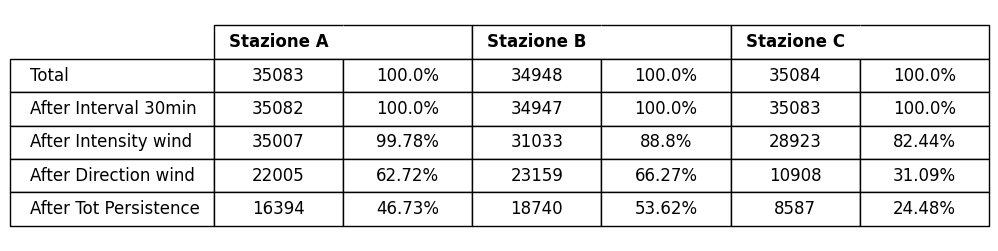

In [99]:
def mergecells(table, ix0, ix1):
    ix0,ix1 = np.asarray(ix0), np.asarray(ix1)
    d = ix1 - ix0
    if not (0 in d and 1 in np.abs(d)):
        raise ValueError("ix0 and ix1 should be the indices of adjacent cells. ix0: %s, ix1: %s" % (ix0, ix1))

    if d[0]==-1:
        edges = ('BRL', 'TRL')
    elif d[0]==1:
        edges = ('TRL', 'BRL')
    elif d[1]==-1:
        edges = ('BTR', 'BTL')
    else:
        edges = ('BTL', 'BTR')

    # hide the merged edges
    for ix,e in zip((ix0, ix1), edges):
        table[ix[0], ix[1]].visible_edges = e

    txts = [table[ix[0], ix[1]].get_text() for ix in (ix0, ix1)]
    tpos = [np.array(t.get_position()) for t in txts]

    # center the text of the 0th cell between the two merged cells
    trans = (tpos[1] - tpos[0])/2
    if trans[0] > 0 and txts[0].get_ha() == 'right':
        # reduce the transform distance in order to center the text
        trans[0] /= 2
    elif trans[0] < 0 and txts[0].get_ha() == 'right':
        # increase the transform distance...
        trans[0] *= 2

    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))

    # hide the text in the 1st cell
    txts[1].set_visible(False)


stazioni = ["A","B","C"]

dati = []

for stazione in stazioni:
    total = len(globals()["df_"+stazione+"_year"])
    interval = len(globals()["df_"+stazione+"_year_interval30"])
    intensity = len(globals()["df_"+stazione+"_year_interval30_plaus_speed"])
    direction = len(globals()["df_"+stazione+"_year_interval30_plaus_dir"])
    persistence = len(globals()["df_"+stazione+"_year_interval30_plaus_pers3"])

    dati.append([total, interval, direction,  intensity, persistence])
    dati.append([str(round(total/total*100,2))+"%", 
                    str(round(interval/total*100,2))+"%", 
                        str(round(direction/total*100,2))+"%",
                            str(round(intensity/total*100,2))+"%",
                                    str(round(persistence/total*100,2))+"%"])

dati2 = list(map(list, zip(*dati))) #transpose
fig, ax = plt.subplots(figsize=(2, 3))
#ax.set_title("Numero di dati conservati dopo ogni step", loc='right')


rowName = ['Total', 'After Interval 30min', 'After Intensity wind', 'After Direction wind', 'After Tot Persistence']
tabella = ax.table(cellText=dati2, loc='center', cellLoc='center', colLabels=["Stazione A","","Stazione B","","Stazione C",""], rowLabels=rowName)
mergecells(tabella, (0,0), (0,1))
mergecells(tabella, (0,2), (0,3))
mergecells(tabella, (0,4), (0,5))

for i in range(6):
    tabella._cells[0, i].set_text_props(fontweight='bold')
    #tabella._cells[i, -1].set_text_props(fontweight='bold')
    
tabella.auto_set_font_size(False)
tabella.set_fontsize(12)
tabella.scale(5, 2)
ax.axis('off')

plt.savefig('FIGURE/wind_data_conserved.png', dpi=300, bbox_inches='tight')
plt.show()

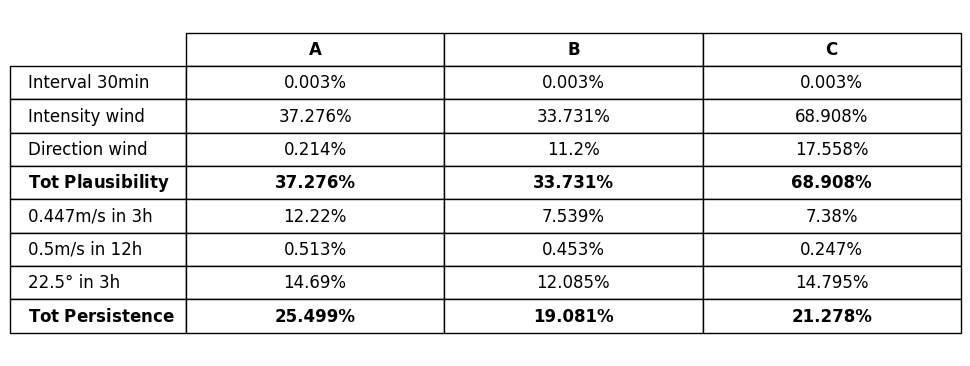

In [100]:
stazioni = ["A","B","C"]

dati = []

for stazione in stazioni:
    total = len(globals()["df_"+stazione+"_year"])
    interval = len(globals()["df_"+stazione+"_year_interval30"])
    intensity = len(globals()["df_"+stazione+"_year_interval30_plaus_speed"])
    direction = len(globals()["df_"+stazione+"_year_interval30_plaus_dir"])
    plausibility = len(globals()["df_"+stazione+"_year_interval30_plaus"])
    per1 = len(globals()["df_"+stazione+"_year_interval30_plaus_pers1"])
    pers2 = len(globals()["df_"+stazione+"_year_interval30_plaus_pers2"])
    persistence = len(globals()["df_"+stazione+"_year_interval30_plaus_pers3"])

    dati.append([str(round((1 - interval/total)*100,3))+"%", 
                    str(round((1 - intensity/interval)*100,3))+"%", 
                        str(round((1 - direction/interval)*100,3))+"%",
                            str(round((1 - plausibility/interval)*100,3))+"%",
                                str(round((1 - per1/plausibility)*100,3))+"%",
                                    str(round((1 - pers2/per1)*100,3))+"%",
                                        str(round((1 - persistence/pers2)*100,3))+"%",
                                            str(round((1 - persistence/plausibility)*100,3))+"%"])


dati2 = list(map(list, zip(*dati))) #transpose
fig, ax = plt.subplots(figsize=(2,4.5))
#ax.set_title("Percentuale dati scartati dai singoli filtri", loc='right')

rowName = ['Interval 30min', 'Intensity wind', 'Direction wind', '$\\bf{Tot}$ $\\bf{Plausibility}$', '0.447m/s in 3h', '0.5m/s in 12h', '22.5° in 3h', '$\\bf{Tot}$ $\\bf{Persistence}$']
tabella = ax.table(cellText=dati2, loc='center', cellLoc='center', colLabels=["A","B","C"], rowLabels=rowName)

for i in range(3):
    tabella._cells[0, i].set_text_props(fontweight='bold')
    tabella._cells[4, i].set_text_props(fontweight='bold')
    tabella._cells[8, i].set_text_props(fontweight='bold')
    
tabella.auto_set_font_size(False)
tabella.set_fontsize(12)
tabella.scale(5, 2)
ax.axis('off')

plt.savefig('FIGURE/wind_filter_statistic.png', dpi=300, bbox_inches='tight')
plt.show()

Si lascia allo studente di implementare autonomamente le condizioni di attendibilità suggerite dall'EPA che tengano in considerazione anche la persistenza della direzione del vento.

<span style="font-size: large;">**ANALISI DATASET FILTRATO**  

In [101]:
for stazione in stazioni:
    print("stazione "+stazione)
    df = globals()["df_"+stazione+"_year_interval30_plaus_pers3"]
    print("max " + str(df['wndSpeed'].max()))
    print("min " + str(df['wndSpeed'].min()))

stazione A
max 5.811
min 0.894
stazione B
max 7.152
min 0.894
stazione C
max 23.691
min 0.894


<span style="font-size: large;">**VISUALIZZAZIONE**  

<span style="font-size: large;">**1. Istogramma delle velocità del vento**  

Andiamo a visualizzare l'istrogramma delle velocità filtrate, suddividendole per stagione.

Come possiamo vedere, il grosso dei dati filtrati viene escluso dal filtro sulla persistenza.  

<span style="font-size: large;">**3. Dati disponibili per mese**  

Analizziamo ora l’andamento mensile delle percentuali di istanti di funzionamento della strumentazione (dati validi) rispetto al totale degli istanti disponibili.

  <span style="font-size: large;">**BOXPLOT**  
  
  I boxplots sono uno strumento grafico utilizzato per visualizzare la distribuzione di un insieme di dati e per identificare le principali caratteristiche statistiche del dataset, quali ad es. media, mediana, primo quartile, terzo quartile, outliers e intervallo di confidenza al 95%.
  
  Si riporta di seguito, giusto a titolo esemplificativo, il boxplot della velocità del vento in funzione della stagione per la sola Stazione A. In questo caso, ciascun boxplot riporta la mediana della distribuzione (linea nera marcata), il primo (Q1) e terzo (Q3) quartile (estensione del boxplot), i valori *Q1-1.5IQR* e *Q3+1.5IQR* (*IQR* sta per *"Inter-quartile range"* ed è calcolato come *Q3-Q1*) (barre nere sottili) e outliers (tutti quei valori al di fuori del range di cui sopra, rappresentati come pallini).

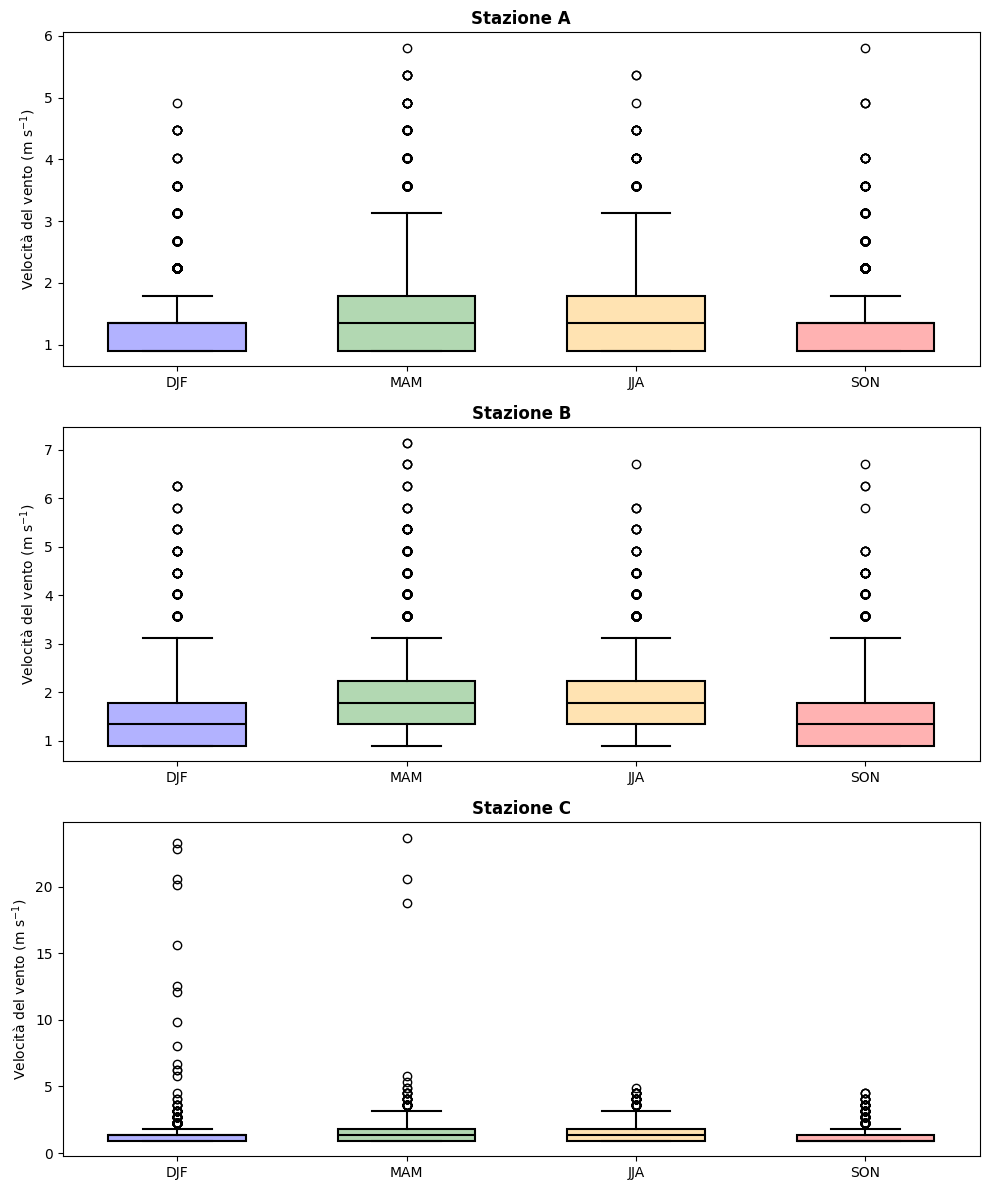

In [102]:
def get_season(month):
    if 3 <= month <= 5:
        return 'MAM'
    elif 6 <= month <= 8:
        return 'JJA'
    elif 9 <= month <= 11:
        return 'SON'
    else:
        return 'DJF'

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

stagioni = ['DJF','MAM','JJA','SON']
colori = ['blue','green','orange','red']

for s, ax in enumerate(axes.flatten()):
    df = globals()["df_"+stazioni[s]+"_year_interval30_plaus_pers3"]
    df['Stagione'] = df['Datetime'].dt.month.apply(get_season)
    #plt.figure(figsize=(10, 4))

    for i in range(len(stagioni)):
        rgb = mcolors.to_rgba(colori[i])
        linewidth = 1.5
        edgecolor = 'black'
        widths=0.6
        data = df['wndSpeed'][df['Stagione']==stagioni[i]]
        ax.boxplot(data, patch_artist=True, positions=np.array([i]),widths=widths,
                    boxprops=dict(facecolor=(rgb[0], rgb[1], rgb[2], 0.3), edgecolor=edgecolor, linewidth=linewidth),
                    medianprops=dict(color=edgecolor, linewidth=linewidth),
                    whiskerprops=dict(color=edgecolor, linewidth=linewidth),
                    capprops=dict(color=edgecolor, linewidth=linewidth),
                    flierprops=dict(markeredgecolor=edgecolor))
        
    ax.set_xticks(np.arange(0,len(stagioni)),stagioni)
    ax.set_ylabel("Velocità del vento (m s$^{-1}$)")
    ax.set_title('Stazione '+stazioni[s], fontweight="bold")
    #ax.set_ylim(-0.5,8)
#fig.title('Boxplots della Velocità del Vento per Stagione', fontweight="bold")
plt.tight_layout()
plt.savefig('FIGURE/speed_distribution.png', dpi=300, bbox_inches='tight')


In [103]:
df = globals()["df_C_year_interval30_plaus_pers3"]
print(df['wndSpeed'].mean())
print(df['wndSpeed'].std())
print(df['wndSpeed'].mean() + 3*df['wndSpeed'].std())

1.3870170024456825
0.8940389861589626
4.069133960922571


 <span style="font-size: large;">**ROSE VENTI**  

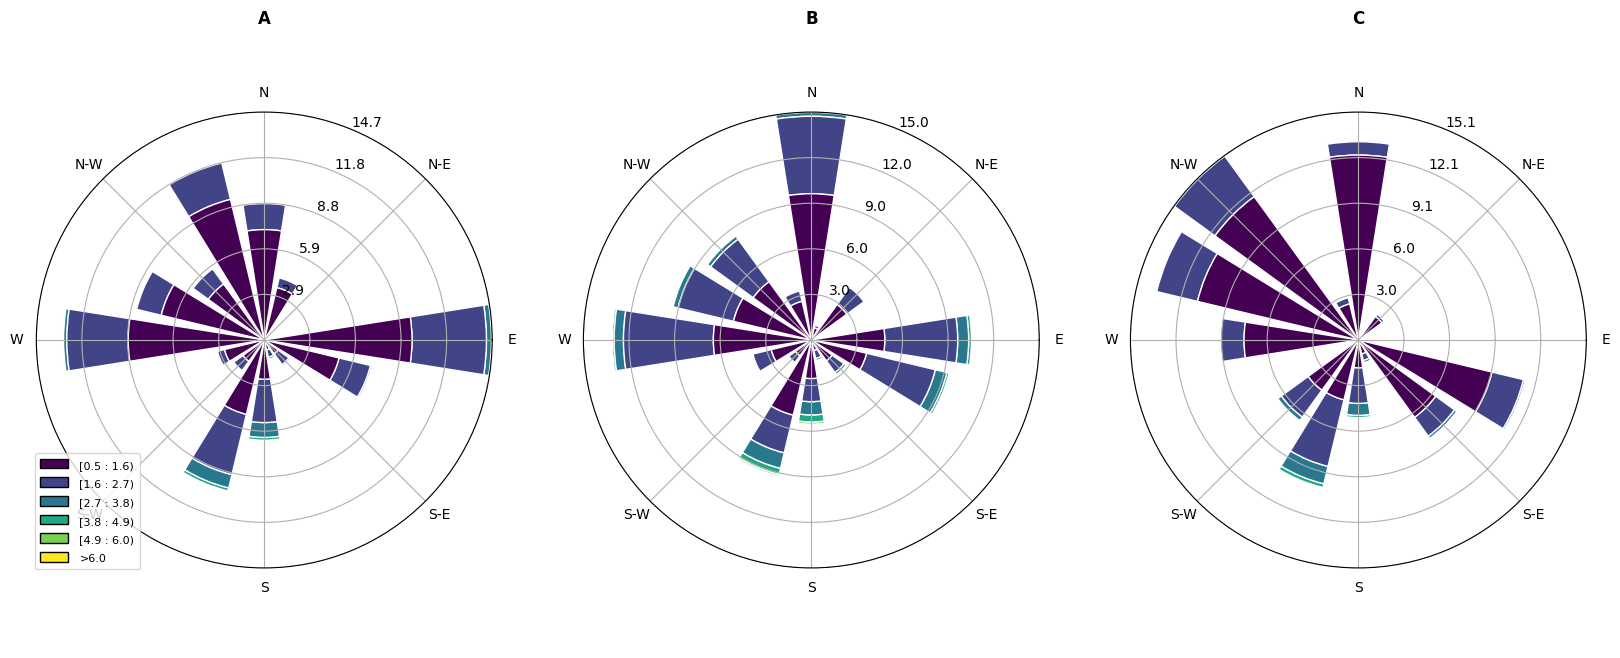

In [104]:
from windrose import WindroseAxes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

for i in range(3):
    axes[i].axis('off')
    axes[i].set_title("$\\bf{"+stazioni[i]+"}$")
    rect=axes[i].get_position()
    wa = WindroseAxes(fig, rect)
    fig.add_axes(wa)

    ws = globals()["df_"+stazioni[i]+"_year_interval30_plaus_pers3"]["wndSpeed"]
    wd = globals()["df_"+stazioni[i]+"_year_interval30_plaus_pers3"]["wndDir"]
    
    bins = np.linspace(0.5,6,6) #per avere scala colori comune, estremi dei bin
    wa.bar(wd, ws, normed=True, opening=0.8, edgecolor="white", bins=bins)
    if i == 0:
        wa.set_legend()

plt.savefig('FIGURE/windrose_davis.png', dpi=300, bbox_inches='tight')

<span style="font-size: large;">**CONFRONTO TRA STAZIONI DIVERSE**  

Un altro step importante dell'esperienza di laboratiorio è confrontare i dati delle stazioni Davis e, inoltre, valutare la loro rappresentatività tramite il confronto con i dati ufficiali ARPAE.  

Prima di procedere con l'analisi dei dati ARPAE, andiamo a vedere brevemente qualche possibile analisi da sviluppare per il confronto di due stazioni di misura.  

A tal fine, si crea un dataset fittizio da paragonare con i dati della stazione A.

In [71]:
import pandas as pd
import numpy as np

df = df_A_year_interval30_plaus_pers3.copy()

df_new = df_A_year_interval30_plaus_pers3.copy()
# Aggiungiamo un rumore casuale alla velocità del vento
df_new['wndSpeed'] = df_new['wndSpeed'] * (np.random.normal(loc=1, scale=0.2, size=len(df)) +
                                           np.random.normal(loc=0, scale=0.3, size=len(df)))

# Riporta alla risoluzione originale
df_new['wndSpeed'] = 0.447 * (df_new['wndSpeed'] // 0.447)

Per confrontare i dati di due stazioni, si possono adoperare diversi indici statistici, quali ad esempio:
- Indice di correlazione,
- Mean Error (ME),
- Mean Absolute Error (MAE),
- Root Mean Square Error (RMSE),
- RMSE normalizzato con la media del dataset di riferimento,

Al fine di evitare di riscrivere le singole funzioni per ogni comparazione tra singole coppie di stazioni e rendere lo script eccessivamente lungo e ridondante, conviene definire una funzione con cui calcolare tutti gli indici desiderati e richiamarla ogni qualvolta se ne abbia bisogno.

In [ ]:
def statistics(var,ref):
    
    # INPUT:
    # - var: Dataframe with the variable of interest
    # - ref: Reference dataframe with the variable of interest
    # Per avere senso fisico, "var" e "ref" devono avere le stesse date
    
    # OUTPUT:
    # - CORR: Correlation
    # - ME: Mean Error
    # - MAE: Mean Absolute Error
    # - RMSE: Root Mean Square Error
    # - nRMSE: Normalized RMSE
    
    CORR = var.corrwith(ref)[0]
    ME = np.mean(np.subtract(var, ref))
    MAE = np.mean(np.abs(np.subtract(var, ref)))
    RMSE = np.sqrt(np.nanmean(np.square(np.subtract(var, ref))))
    nRMSE = RMSE / np.nanmean(ref)
    
    return CORR, ME, MAE, RMSE, nRMSE

corr,me,mae,rmse,nrmse = statistics(df_new[['wndSpeed']],df[['wndSpeed']])

table = pd.DataFrame({
    'Corr.': [round(corr,3)],
    'ME': [round(me,3)],
    'MAE': [round(mae,3)],
    'RMSE': [round(rmse,3)],
    'normalized RMSE': [round(nrmse,3)]
})

table

In [ ]:
df_new[['wndSpeed']].corrwith(df[['wndSpeed']]).values

Un altro modo per confrontare due datasets è adoperare specifiche rappresentazioni grafiche quali ad esempio istogrammi, diagrammi di dispersione, boxplots, etc. 

Plottiamo di seguito, a titolo di esempio, un grafico a dispersione tra i dati della stazione A e i dati della stazione fittizia, con l'aggiunta della regressione lineare dei dati della stazione fittizia sui dati della stazione A.

In [ ]:
# Regressione Lineare
model = LinearRegression()
model.fit(df['wndSpeed'].to_numpy().reshape((-1, 1)),df_new['wndSpeed'].to_numpy())
intercept = model.intercept_
slope = model.coef_[0]

# Definizione delle grandezze dei marker, in funzione della numerosità
c = Counter(zip(df['wndSpeed'],df_new['wndSpeed']))
s = [0.06*c[(xx,yy)] for xx,yy in zip(df['wndSpeed'],df_new['wndSpeed'])]

fig, ax = plt.subplots(figsize=(8,8))

# Linea diagonale, che rappresenta una relazione lineare tra le due stazioni
ax.axline((1, 1), slope=1, color='lightgrey',linewidth=0.5)
ax.axline((0, intercept), slope=slope, color='red',linewidth=0.5) 

scatter_plot = plt.scatter(df['wndSpeed'], df_new['wndSpeed'],s=s,color='blue',label='Numero di occorrenze')

plt.xlabel('Stazione A (m s$^{-1}$)')
plt.ylabel('Stazione Fittizia (m s$^{-1}$)')
plt.xlim(-1,12)
plt.ylim(-1,12)

ax.legend(*scatter_plot.legend_elements(prop="sizes", num=[1,10,30,50,100,200],color='blue'), loc=(0.84,0.01),title='Numerosità')

plt.text(8,6.9,f'y = {round(intercept,2)} + {round(slope,2)}*x',rotation=np.rad2deg(math.atan(slope)),color='red')
plt.title('Velocità del vento\nStazione A vs Stazione Fittizia', fontweight="bold")

plt.show()

<span style="font-size: large;">**DATI ARPAE**  
    
I dati delle stazioni della rete regionale ARPAE sono scaricabili liberamente dalla piattaforma dext3r (https://simc.arpae.it/dext3r/) selezionando il periodo e le variabili prescelte.

In [31]:
percorso = "C:/Users/luca.famoosspaolini/Desktop/Laboratorio/DATI_ARPAE/"

year = ['2014','2015','2016']

for y in year:

    file = percorso+f'{y}.csv'
    
    # Eliminiamo le prime 6 righe che sono dati testuali e gli ultimi valori dell'anno precedente
    df = pd.read_csv(file, encoding='ISO-8859-1',names=['Datetime','Fine validità (UTC)','wndSpeed'],
                     skiprows=6,on_bad_lines='skip')
    # Eliminiamo inoltre le ultime righe che hanno solo dati testuali
    df = df[:-2]
    # Eliminiamo la colonna "Fine validità (UTC)" in quanto disponiamo dell'informazione sulla data già dalla prima colonna.
    # La seconda colonna ci sta solo ad indicare che le misure sono misure di vento orarie (come già noto dal sito web ARPAE).
    df.drop(df.columns[1],axis=1, inplace=True)
    
    # Trasformiamo la colonna tempo in formato Data Anno-Mese-Giorno ora:minuto (come fatto in precedenza)
    df['Datetime'] = pd.to_datetime(df['Datetime']).dt.strftime('%Y-%m-%d %H:%M:00')
    
    globals()['df_'+y] = df

# Infine, concateniamo i tre dataframe lungo la dimensione temporale, per creare un unico dataframe ARPAE
df_ARPAE = pd.concat([df_2014, df_2015, df_2016], axis=0, ignore_index=True)

In [ ]:
df_ARPAE

"Datetime" è fornito nella scalata temporale Coordinated Universal Time (UTC), mentre le stazioni Davis di UniBo sono in ora locale (timezone CET). Dobbiamo quindi convertire le stazioni Davis di UniBo nel formato UTC, al fine di rendere paragonabili le misure.  

Per farlo, adoperiamo il pacchetto Python *"pytz"*.

In [ ]:
df_A = df_A_year_interval30_inten_dir_pers.copy()

# Prima dobbiamo definire la scala temporale del date delle stazioni, vale a dire "Europe/Rome".
time = df_A.Datetime.dt.tz_localize("Europe/Rome",ambiguous='NaT')

# Poi, possiamo convertirle in 'UTC' e riscriverlo nel formato Anno-Mese-Giorno Ora:minuto:00
df_A['Datetime'] = time.dt.tz_convert('UTC').dt.strftime('%Y-%m-%d %H:%M:00')

# Come potete vedere, le date in 'Datetime' sono state anticipate.
df_A

A questo punto, possiamo confrontare la stazione A con la stazione ARPAE, facendo attenzione a garantire la corrispondenza temporale dei due datasets.  

A titolo di esempio, si riporta il grafico a dispersione dell'intensità del vento per le due stazioni.

In [ ]:
df_A = df_A[['Datetime','wndSpeed']]
df_merged = pd.merge(df_A, df_ARPAE, on='Datetime', suffixes=('_A', '_ARPAE'))
df_merged = df_merged.dropna()

# Regressione Lineare
model = LinearRegression()
model.fit(df_merged['wndSpeed_ARPAE'].to_numpy().reshape((-1, 1)),df_merged['wndSpeed_A'].to_numpy())
intercept = model.intercept_
slope = model.coef_[0]

# Definizione delle grandezze dei marker, in funzione della numerosità
c = Counter(zip(df_merged['wndSpeed_ARPAE'],df_merged['wndSpeed_A']))
s = [0.2*c[(xx,yy)] for xx,yy in zip(df_merged['wndSpeed_ARPAE'],df_merged['wndSpeed_A'])]

fig, ax = plt.subplots(figsize=(8,8))

# Linea diagonale, che rappresenta una relazione lineare tra le due stazioni
ax.axline((1, 1), slope=1, color='lightgrey',linewidth=0.5)
ax.axline((0, intercept), slope=slope, color='red',linewidth=0.5) 

scatter_plot = plt.scatter(df_merged['wndSpeed_ARPAE'],df_merged['wndSpeed_A'],s=s,color='blue',label='Numero di occorrenze')

plt.xlabel('Stazione ARPAE (m s$^{-1}$)')
plt.ylabel('Stazione A (m s$^{-1}$)')
plt.xlim(-1,12)
plt.ylim(-1,12)

ax.legend(*scatter_plot.legend_elements(prop="sizes", num=[1,10,20,30,60],color='blue'), loc=(0.84,0.01),title='Numerosità')

plt.text(8,3.5,f'y = {round(intercept,2)} + {round(slope,2)}*x',rotation=np.rad2deg(math.atan(slope)),color='red')
plt.title('Velocità del vento\nStazione ARPAE vs Stazione A', fontweight="bold")

plt.show()


Come ulteriore esempio, plottiamo gli istrogrammi delle due stazioni nel medesimo plot.

In [ ]:
df_merged

fig_hist = plt.figure(figsize=(8, 6))

bins = np.arange(-0.25,6,0.5)

hist = sns.histplot(data=df_merged[['wndSpeed_A','wndSpeed_ARPAE']].melt(), x='value', hue='variable', bins=bins, 
             multiple='dodge',palette={'wndSpeed_A': 'darkblue', 'wndSpeed_ARPAE': 'darkorange'})

# ISTOGRAMMI delle singole stazioni
#sns.histplot(df_merged['wndSpeed_A'], bins=bins,kde=False, color='blue')
#sns.histplot(df_merged['wndSpeed_ARPAE'], bins=bins,kde=False, color='orange')

plt.title('Istogramma velocità del vento',fontweight='bold')
plt.xlabel("Velocità del vento (m s$^{-1}$)")
plt.ylabel("Numero di misure")
plt.ylim(0,6000)
plt.xlim(-0.5,6.5)

legend = hist.get_legend()
handles = legend.legendHandles
legend.remove()
plt.legend(handles, ['Stazione A', 'Stazione ARPAE'])

plt.tight_layout()
plt.show()

In [37]:
# 2. DATI per rosa dei venti

# Selezioniamo solo i dati all'inizio dell'ora
df = df_A_year_interval30_inten_dir_pers.copy()
df = df[df['Datetime'].dt.minute == 0]
df = df[['Datetime','wndSpeed','wndDir']]

# Ristrutturiamo i dati nel formato richiesto da WRPlot

df_WRPlot = pd.DataFrame({
    'StID': [12345] * len(df),
    'YYYY': df['Datetime'].dt.year.apply(pd.to_numeric),
    'MM': df['Datetime'].dt.month.apply(pd.to_numeric),
    'DD': df['Datetime'].dt.day.apply(pd.to_numeric),
    'HH': df['Datetime'].dt.hour.apply(pd.to_numeric),
    'Dir': df['wndDir'].apply(pd.to_numeric).astype(int),
    'WS': (1.94384 * df['wndSpeed']).apply(pd.to_numeric).astype(int) # (1 knot = 1.94384 m/s)
})

percorso = "C:/Users/luca.famoosspaolini/Desktop/Laboratorio/DATI_PROCESSATI/"
df_WRPlot.to_csv(percorso+'Venti_Stazione_A.txt', sep='\t',index = False, header=False)

file_path = percorso+'Venti_Stazione_A.txt'

with open(file_path, 'r') as file:
    contenuto = file.read()

with open(file_path, 'w') as file:
    file.write("LAKES FORMAT" + "\n" + contenuto)